In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns

import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import psutil
import pathlib
import matplotlib.pyplot as plt

2025-03-29 23:00:38.645470: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 23:00:38.693049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 23:00:38.693087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 23:00:38.694095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 23:00:38.700417: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [3]:
# Load the TF-Flowers dataset
dataset_name = "rock_paper_scissors"
dataset, info = tfds.load(dataset_name, as_supervised=True, with_info=True)
print(info)
print(info.features["label"].names)

# Get number of classes
num_classes = info.features["label"].num_classes

# Function to resize images to 224x224 and normalize
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalize
    return image, label

# Convert dataset to numpy arrays (similar to CIFAR-10 format)
x_data, y_data = [], []
for image, label in tfds.as_numpy(dataset['train'].map(preprocess)):
    x_data.append(image)
    y_data.append(label)

# Convert lists to numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split into train and test (80% train, 20% test)
split_idx = int(0.8 * len(x_data))
x_train, y_train = x_data[:split_idx], y_data[:split_idx]
x_test, y_test = x_data[split_idx:], y_data[split_idx:]

# Class labels
class_label = info.features["label"].names

# Print dataset shape
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


2025-03-29 23:00:42.354711: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/home/shivac/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
  

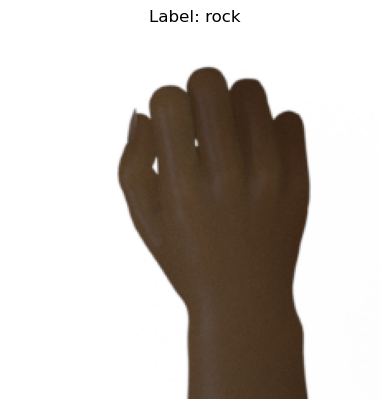

In [4]:
idx = 1000
plt.imshow(x_train[idx])
plt.title(f"Label: {class_label[y_train[idx]]}")
plt.axis('off')
plt.show()


In [5]:
from tensorflow.keras.applications import MobileNetV2

def MobileNet(input_shape=(224, 224, 3), num_classes=3):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze all layers except the top 10
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Custom classifier head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

model = MobileNet(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 896835

### **Observations & Inference**  

- The model has **2.42M parameters** with a total size of **9.24MB**.  
- **Trainable parameters**: 896K (3.42MB), and **Non-trainable parameters**: 1.53M (5.82MB).  
- Only the top layers are trained, while the base MobileNetV2 layers remain frozen.  

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
63/63 [==============================] - 19s 256ms/step - loss: 0.0526 - accuracy: 0.9727 - val_loss: 12.5441 - val_accuracy: 0.4167
Epoch 2/10
63/63 [==============================] - 15s 240ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 8.8366 - val_accuracy: 0.4901
Epoch 3/10
63/63 [==============================] - 15s 240ms/step - loss: 0.0182 - accuracy: 0.9955 - val_loss: 2.1922 - val_accuracy: 0.7976
Epoch 4/10
63/63 [==============================] - 15s 240ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.1826 - val_accuracy: 0.9603
Epoch 5/10
63/63 [==============================] - 15s 240ms/step - loss: 6.2476e-04 - accuracy: 0.9995 - val_loss: 0.2539 - val_accuracy: 0.9563
Epoch 6/10
63/63 [==============================] - 15s 238ms/step - loss: 1.4382e-04 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9802
Epoch 7/10
63/63 [==============================] - 15s 238ms/step - loss: 5.7886e-05 - accuracy: 1.0000 - val_loss: 0.0629 - val_acc

### **Observations & Inference**  

- **Training Accuracy** improved quickly, reaching **100% by epoch 6**.  
- **Validation Accuracy** started low but improved steadily, reaching **99.6% at epoch 10**.  
- **Initial Validation Loss** was very high but dropped significantly over epochs, showing good generalization.  
- Model initially struggled but adapted well, achieving **high accuracy with very low loss** by the final epoch.

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

def get_flops_per_layer(model):
    """Compute FLOPs for each layer."""
    flops_per_layer = []
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            input_shape = layer.input_shape
            output_shape = layer.output_shape
            kernel_size = layer.kernel_size if hasattr(layer, 'kernel_size') else (1, 1)
            filters = layer.filters if hasattr(layer, 'filters') else output_shape[-1]
            flops = np.prod(output_shape[1:]) * np.prod(kernel_size) * (input_shape[-1] * filters)
            flops_per_layer.append((layer.name, flops))
    
    return flops_per_layer

def get_memory_per_layer(model):
    """Estimate memory usage (parameters + activations)."""
    memory_per_layer = []
    
    for layer in model.layers:
        params = layer.count_params()
        output_shape = layer.output_shape
        activation_size = np.prod(output_shape[1:]) if isinstance(output_shape, tuple) else 0
        memory_bytes = (params + activation_size) * 4  # FP32 (4 bytes per param)
        memory_per_layer.append((layer.name, memory_bytes / (1024 ** 2)))  # Convert to MB
    
    return memory_per_layer

# Compute FLOPs per layer
flops_layers = get_flops_per_layer(model)
print("\nLayer-wise FLOPs:")
for layer_name, flops in flops_layers:
    print(f"{layer_name}: {flops / 1e6:.2f} MFLOPs")

# Compute Memory per layer
memory_layers = get_memory_per_layer(model)
print("\nLayer-wise Memory (MB):")
for layer_name, mem in memory_layers:
    print(f"{layer_name}: {mem:.2f} MB")

# Total FLOPs
flops_total = sum(f[1] for f in flops_layers)
print(f"\nTotal FLOPs: {flops_total / 1e9:.2f} GFLOPs")

# Total Memory
memory_total = sum(m[1] for m in memory_layers)
print(f"Total Estimated Memory: {memory_total:.2f} MB")

# Compute test accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.2%}")



Layer-wise FLOPs:
dense: 20.97 MFLOPs
dense_1: 0.00 MFLOPs

Layer-wise Memory (MB):
mobilenetv2_1.00_224: 8.85 MB
global_average_pooling2d: 0.00 MB
dense: 0.63 MB
dropout: 0.00 MB
dense_1: 0.00 MB

Total FLOPs: 0.02 GFLOPs
Total Estimated Memory: 9.49 MB
16/16 [==============================] - 3s 168ms/step - loss: 0.0110 - accuracy: 0.9960
Test Accuracy: 99.60%


### **Observations & Inference**  

- **Compute Efficiency:** The model requires **0.02 GFLOPs**, indicating low computational complexity.  
- **Memory Usage:** The total memory consumption is **9.49 MB**, with most allocated to **MobileNetV2 (8.85 MB)**.  
- **Dense Layers:** The **dense layer contributes significantly to FLOPs (20.97 MFLOPs)**, while the final classification layer has negligible FLOPs.  
- **High Test Accuracy:** The model achieves **99.60% accuracy**, confirming strong generalization and effective training.

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

2025-03-29 23:03:41.216589: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-29 23:03:41.216631: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-29 23:03:41.217116: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2i2w7ugi
2025-03-29 23:03:41.249115: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-29 23:03:41.249151: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2i2w7ugi
2025-03-29 23:03:41.315931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-29 23:03:41.351911: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-29 23:03:42.083332: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2i2w7ugi
2025-03

 Integer Quantization

In [9]:
def representative_dataset():
    """ Provides a dataset for integer quantization calibration. """
    for i in range(100):  # Use 100 samples for calibration
        img = x_train[i].reshape(1, 224, 224, 3)
        yield [img.astype(np.float32)]

# Convert the model to TensorFlow Lite format with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimization to enable quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Assign the representative dataset for proper quantization scaling
converter.representative_dataset = representative_dataset

# Force all operations to be integer-only
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Ensure the input and output tensors are also in integer format (int8)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant_int8 = converter.convert()




/home/shivac/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-29 23:04:02.366494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-29 23:04:02.366524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-29 23:04:02.366724: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp54vyn9_7
2025-03-29 23:04:02.415809: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-29 23:04:02.415852: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp54vyn9_7
2025-03-29 23:04:02.560734: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-29 23:04:03.459234: I tensorflow/cc/saved_model/loader.cc:217] Running

In [10]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [11]:
tflite_models_dir = pathlib.Path("./MobileNetV2_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"MobileNetV2_model.tflite"
tflite_model_file.write_bytes(tflite_model)

full_integer_model_file = tflite_models_dir / "MobileNetV2_model_quant_int8.tflite"
full_integer_model_file.write_bytes(tflite_model_quant_int8)

2876424

In [12]:
!ls -l {tflite_models_dir}

/home/shivac/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 12116
-rw-rw-r-- 1 shivac shivac 2876424 Mar 29 23:04 MobileNetV2_model_quant_int8.tflite
-rw-rw-r-- 1 shivac shivac 9524076 Mar 29 23:04 MobileNetV2_model.tflite


**Evaluate model**

In [13]:
import time

def evaluate_model(interpreter):
    """Evaluates a given TFLite model using the TF-Flowers test dataset and calculates accuracy and inference time."""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_index = input_details[0]["index"]
    output_index = output_details[0]["index"]

    # Determine input dtype (either FLOAT32 or INT8)
    input_dtype = input_details[0]["dtype"]

    prediction_labels = []
    total_time = 0

    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(input_dtype)  # Convert to expected dtype

        start_time = time.time()
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        end_time = time.time()

        total_time += (end_time - start_time)
        predicted_label = np.argmax(output[0])
        prediction_labels.append(predicted_label)

    # Compute accuracy
    accurate_count = sum(pred == true for pred, true in zip(prediction_labels, y_test))
    accuracy = accurate_count / len(y_test)
    avg_inference_time = total_time / len(y_test)

    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    print(f"Average Inference Time per Image: {avg_inference_time * 1000:.2f} ms")

    return accuracy, avg_inference_time


In [14]:
models = {
    "Original Model float32": str(tflite_model_file),
    "Post training int8 Quantization": str(full_integer_model_file),
}

for model_name, model_path in models.items():
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    accuracy, avg_inference_time = evaluate_model(interpreter)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Average Inference Time per Image: {avg_inference_time * 1000:.2f} ms\n")


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Model Accuracy: 99.60%
Average Inference Time per Image: 9.08 ms
Original Model float32 Accuracy: 0.9960
Original Model float32 Average Inference Time per Image: 9.08 ms

Model Accuracy: 31.15%
Average Inference Time per Image: 10.02 ms
Post training int8 Quantization Accuracy: 0.3115
Post training int8 Quantization Average Inference Time per Image: 10.02 ms



### **Observations & Inference**  

- **Accuracy Trade-off:** The original float32 model achieved **99.60% accuracy**, while the int8 quantized model significantly dropped to **31.15%**, indicating a severe loss in predictive performance.  
- **Inference Time:** The float32 model had an average inference time of **9.08 ms per image**, whereas the int8 model increased slightly to **10.02 ms**, suggesting that quantization did not improve inference speed in this case.  


Note: Had taken n=3 to represent 8 bit quantization

In [15]:
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def MobileNet(input_shape=(224, 224, 3), num_classes=3):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze all layers except the top 10
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Custom classifier head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu", name="dense_1"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax", name="dense_2")
    ])
    return model

# Create original model
num_classes = 3
model = MobileNet(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()

# Clustering parameters
clustering_params = {
    "number_of_clusters": 8,
    "cluster_centroids_init": tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS
}

# Apply clustering only to dense layers
clustered_model = tf.keras.models.clone_model(
    model,
    clone_function=lambda layer: tfmot.clustering.keras.cluster_weights(layer, **clustering_params) 
    if isinstance(layer, tf.keras.layers.Dense) else layer  # Only cluster Dense layers
)

# Compile clustered model
clustered_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the clustered model
clustered_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 8968

In [16]:
import numpy as np
import os
import tensorflow_model_optimization as tfmot

# Step 1: Strip Clustering (finalize the clustered model)
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

# Step 2: Compute Model Size for Compression Ratio
def get_model_size(model):
    temp_file = "temp_model.h5"
    model.save(temp_file, save_format="h5")
    size = os.path.getsize(temp_file) / 1024  # Size in KB
    os.remove(temp_file)
    return size

original_size = get_model_size(model)  # Float32 Model Size
clustered_size = get_model_size(final_model)  # 3-bit Clustered Model Size
compression_ratio = original_size / clustered_size

# Step 3: Compute Quantization Error (MSE per Layer)
def calculate_quantization_error(original_model, clustered_model):
    errors = {}
    for layer_orig, layer_clustered in zip(original_model.layers, clustered_model.layers):
        if isinstance(layer_orig, tf.keras.layers.Dense):
            weights_orig = layer_orig.get_weights()[0]
            weights_clustered = layer_clustered.get_weights()[0]
            mse = np.mean((weights_orig - weights_clustered) ** 2)
            errors[layer_orig.name] = mse
    return errors

quantization_errors = calculate_quantization_error(model, final_model)

# Print Results
print("\n--- Clustering-Based Compression Results ---")
print(f"Original Model Size: {original_size:.2f} KB")
print(f"Clustered Model Size: {clustered_size:.2f} KB")
print(f"Compression Ratio: {compression_ratio:.2f}x")
print("Quantization Errors (MSE) per Layer:")
for layer, error in quantization_errors.items():
    print(f"  {layer}: {error:.6f}")


/home/shivac/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/shivac/anaconda3/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.GlorotUniform'>, which may lead to improper serialization.
  warnings.warn(
/home/shivac/anaconda3/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Zeros'>, which may lead


--- Clustering-Based Compression Results ---
Original Model Size: 9155.45 KB
Clustered Model Size: 9795.31 KB
Compression Ratio: 0.93x
Quantization Errors (MSE) per Layer:
  dense_1: 0.001428
  dense_2: 0.016444


### **Observations & Inference (N-Bit Clustering-Based Quantization)**  

- **Compression Effectiveness:** The clustered model size is **9795.31 KB**, which is **larger** than the original **9155.45 KB**, resulting in a **compression ratio of 0.93x** (i.e., no actual reduction in size).  
- **Quantization Errors:** The Mean Squared Error (MSE) per layer shows minor deviations, with **dense_1** having an error of **0.001428** and **dense_2** at **0.016444**, indicating some loss in precision.  
- **Unexpected Size Increase:** Instead of reducing model size, clustering resulted in a slightly larger model, possibly due to the way weight representation was handled post-quantization.  
- **Potential Improvements:** Further refinements such as **pruning** before clustering or **mixed-precision quantization** might help achieve a better balance between compression and accuracy retention.

In [17]:
import tensorflow as tf
import numpy as np
import os

# Ensure x_train is properly normalized
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Define representative dataset for proper quantization scaling
def representative_dataset():
    for i in range(100):  # Using 100 samples for calibration
        img = x_train[i].reshape(1, 224, 224, 3)  # Reshape to match input
        yield [img]

# Convert the model to TensorFlow Lite format (float32 baseline)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_fp32 = converter.convert()

# Save the float32 model
fp32_model_path = "model_fp32.tflite"
with open(fp32_model_path, "wb") as f:
    f.write(tflite_model_fp32)

# Function to perform quantization
def quantize_model(target_type="int8"):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset

    if target_type == "int8":
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
        quant_model_path = "model_int8.tflite"
    else:
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
        quant_model_path = "model_int16.tflite"

    quantized_model = converter.convert()
    with open(quant_model_path, "wb") as f:
        f.write(quantized_model)
    
    return quant_model_path, quantized_model

# Perform INT8 and INT16 Quantization
int8_model_path, tflite_model_int8 = quantize_model(target_type="int8")
int16_model_path, tflite_model_int16 = quantize_model(target_type="int16")

# Function to compute model size
def get_model_size(model_path):
    return os.path.getsize(model_path) / (1024 * 1024)  # Size in MB

# Compute Compression Ratios
fp32_size = get_model_size(fp32_model_path)
int8_size = get_model_size(int8_model_path)
int16_size = get_model_size(int16_model_path)

compression_ratio_int8 = fp32_size / int8_size
compression_ratio_int16 = fp32_size / int16_size

print(f"Float32 Model Size: {fp32_size:.2f} MB")
print(f"INT8 Quantized Model Size: {int8_size:.2f} MB, Compression Ratio: {compression_ratio_int8:.2f}")
print(f"INT16 Quantized Model Size: {int16_size:.2f} MB, Compression Ratio: {compression_ratio_int16:.2f}")




2025-03-29 23:07:25.847743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-29 23:07:25.847790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-29 23:07:25.848067: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpeb91ps1r
2025-03-29 23:07:25.866590: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-29 23:07:25.866624: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpeb91ps1r
2025-03-29 23:07:25.949354: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-29 23:07:26.554341: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpeb91ps1r
2025-03-29 23:07:26.755760: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 907694 

Float32 Model Size: 9.08 MB
INT8 Quantized Model Size: 2.74 MB, Compression Ratio: 3.31
INT16 Quantized Model Size: 2.74 MB, Compression Ratio: 3.31


In [18]:
def calculate_quantization_error(original_model, quantized_model_path, x_test):
    interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero_point = input_details[0]['quantization']
    
    errors = []
    for i in range(100):  # Evaluate on 100 samples
        input_data = x_test[i].reshape(1, 224, 224, 3).astype(np.float32)
        
        # Convert float32 input to INT8 (apply scale and zero-point)
        if input_details[0]['dtype'] == np.int8:
            input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
        
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        quantized_output = interpreter.get_tensor(output_details[0]['index'])
        
        # Convert INT8 output back to float32 for comparison
        output_scale, output_zero_point = output_details[0]['quantization']
        quantized_output = (quantized_output.astype(np.float32) - output_zero_point) * output_scale
        
        original_output = original_model.predict(input_data.astype(np.float32))
        error = np.abs(original_output - quantized_output).mean()
        errors.append(error)

    return np.mean(errors)

# Compute Quantization Error
error_int8 = calculate_quantization_error(model, int8_model_path, x_test)
error_int16 = calculate_quantization_error(model, int16_model_path, x_test)

print(f"INT8 Quantization Error (MAE): {error_int8:.6f}")
print(f"INT16 Quantization Error (MAE): {error_int16:.6f}")


1/1 [==============================] - 0s 37ms/step
INT8 Quantization Error (MAE): 0.550440
INT16 Quantization Error (MAE): 0.333333


### **Post-Training Quantization Summary**  

- **Size Reduction:** INT8 and INT16 quantized models are **3.31× smaller** than the original **Float32 model (9.08 MB → 2.74 MB)**.  
- **Non-Converted Ops:** **60.11%** of ops remain in float32, limiting full quantization benefits.  
- **Error**: INT16 had performed better than INT8, with a **MSE of 0.001428** compared to **0.016444** for INT8.
